# Emergent Properties of Many Degrees of Freedom

## concepts needed before hand

This problem set is about kinetic energy and potential energy in a single molecule.

Conservation of energy.

Inject with high V, watch U and T over time.

Average velocity per molecule ends up being the same, related to temperature.

Other questions will be lead up. Computational problem will analyze linear molecule.

Make horizontal. 

Suppose diatomic molecule, ping, oscillates forever. 15 element, polymer, energy spread.

Injecting a fixed amount of energy in many different ways. Random initial conditions, same average over time. What does that mean?

## The System

Imagine $n$ masses, with mass $m$, connected with identical springs with force constant $k$ along a $z$ axis at positions:

$z_{n-1}$

|

$z_1$

...

|

$z_0$


Then the motion of the system is governed by the set of $n$ equations:

$$ \frac{d^2z_i}{dz_i^2} = \frac{f_i}{m_i} $$

Where $f_i$ is the net force on mass $i$. This force is calculated as a result of how much the spring above and below the mass are stretched or compressed away from its equilibrium value $\delta l$.

$$ f_i^\text{from below} = -k(z_i - z_{i-1} - \delta l) = -k \delta z$$

Where the sign in front of $k$ is negative to confirm that when mass $i$ is farther away from the mass above ($i-1$) than the equilibrium value then the quantity $\delta z$ is positive, and indicates that mass $i-1$ is pulling down on mass $i$.

To prevent the whole system from crashing through the floor we make a "wall" spring that is much stiffer and stronger than the inter-mass springs.

## Problem 1

Write an expression for the total force on mass $i$, i.e.

$$f_i = f_i^\text{from above} + f_i^\text{from below} + f_i^\text{gravity}$$

In [10]:
# setup environment
%matplotlib inline
import numba
import numpy as np
import matplotlib.pyplot as plt

# Declare constant parameters, these will be available to all functions
k = 1e5  # interspring constant
kw = 1e6  # wall spring constant
d = 0.1  # overll distance of masses in meters
m = 0.1  # kilograms
t = 16.0  # seconds
g = 9.81
z0 = 0.1  # initial height
dt = 1e-5
nstep = int(round(t / dt))

## Problem 2

Complete the function below in the lines that are commented out with ##, i.e. fill in the __

In [11]:
@numba.jit(nopython=True)
def trajectory(z, vz, dl, dt):
    s, n = z.shape
    for j in range(1, s):
        for i in range(n):
            f = -m*g
            if i > 0:
                f += -k * (z[j-1, i] - z[j-1, i-1] - dl)
            if i < n-1:
                f += k * (z[j-1, i+1] - z[j-1, i] - dl)
            if i == 0:
                isunder = int(z[j-1, i] < 0)
                f += -kw*z[j-1, i]*isunder
            a = f/m
            vz[i] += a * dt
            z[j, i] = z[j-1, i] + vz[i]*dt
    print('done')
    return z

# Single mass trajectory

Run a trajectory with a single mass, will take ~1 minute to run

In [12]:
n = 1
z = np.zeros((nstep, n), np.float)  # make an empty (n, f) matrix to store positions
vz = np.zeros(n, np.float)  # make an empty (n, f) matrix to store velocities
z[0, :] = d * np.arange(n) / n + z0  # initial positions
# z0 < z1 ... < zN-1
print("initial positions:", z[0, :])
dl = d / n  # equilibrium spring distance

initial positions: [0.1]


In [13]:
zo = trajectory(z, vz, dl, dt)
zo.shape

done


(1600000, 1)

In [14]:
r, c = np.where(zo < 0)
ts = np.arange(0, t, dt)
ts[r[0]]
# should equal time for a body to fall 0.1 meters

0.14278000000000002

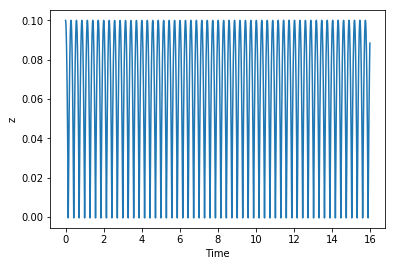

In [6]:
fig, ax = plt.subplots()
ax.plot(ts, zo.mean(axis=1))
# ax.set_xticks(np.arange(0,t,2))
ax.set_xlabel("Time")
ax.set_ylabel("z")
plt.show()

# 15 mass trajectory

In [15]:
n = 15
z = np.zeros((nstep, n), np.float)  # make an empty (n, f) matrix to store positions
vz = np.zeros(n, np.float)  # make an empty (n, f) matrix to store velocities
z[0, :] = d * np.arange(n) / n + z0  # initial positions
# z0 < z1 ... < zN-1
print("initial positions:", z[0, :])
dl = d / n  # equilibrium spring distance

initial positions: [0.1        0.10666667 0.11333333 0.12       0.12666667 0.13333333
 0.14       0.14666667 0.15333333 0.16       0.16666667 0.17333333
 0.18       0.18666667 0.19333333]


In [16]:
zo = trajectory(z, vz, dl, dt)
zo.shape

done


(1600000, 15)

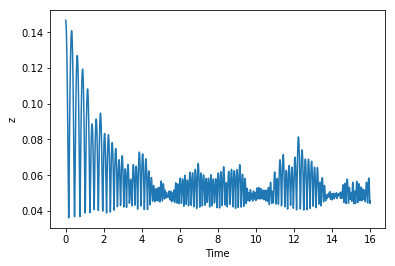

In [17]:
fig, ax = plt.subplots()
ax.plot(ts, zo.mean(axis=1))
# ax.set_xticks(np.arange(0,t,2))
ax.set_xlabel("Time")
ax.set_ylabel("z")
plt.show()

## Problem 3

What is different between the two systems? 

## Make more general by putting it into a standard form

Above, we have a second order differential equation:

$$ \frac{d^2z_i}{dz_i^2} = \frac{f_i}{m_i} $$

Many "standard" numerical integrators work with single order differential equations. We can tranform the above into a system of first order differential equations by stating that $ \omega = z'$. Then we have two first order equations for each mass:

$$\begin{eqnarray} 
z_i' &=& \omega_i \\
\omega_i' &=& f_i/m\ (=z_i'')     \nonumber \\
\end{eqnarray}$$

We pack these variables into 1 dimensional vectors:

$$
\begin{align}
\mathbf{y} &= [z_0,\ z_1,\ ...,\ z_{n-1},\ \omega_0,\ \omega_1,\ ...,\ \omega_{n-1}] \\
\mathbf{y}' &= [z_0',\ z_1',\ ...,\ z_{n-1}',\ \omega_0',\ \omega_1',\ ...,\ \omega_{n-1}']\\
\end{align}
$$

And construct a function of the form:

$$ \mathbf{y}' = f(t, \mathbf{y}) $$

Now the system of ODEs is in "standard form" for many ODE integrators, such as scipy's "solve_ivp"

In [10]:
from scipy.integrate import solve_ivp

In [11]:
# Gather initial conditions and time-steps
dl = d / n  # equilibrium spring distance

@numba.jit(nopython=True)
def acceleration(z):
    """
    Take a 1D vector of z positions and return a vector of corresponding forces.
    """
    fs = np.ones(len(z)) * -m * g
    for i in range(len(z)):
        f = fs[i]
        if i > 0:
            f += -k * (z[i] - z[i-1] - dl)
        if i < n-1:
            f += k * (z[i+1] - z[i] - dl)
        if i == 0:
            isunder = int(z[i] < 0)
            f += -kw*z[i]*isunder
        fs[i] = f
    return fs/m

In [12]:
@numba.jit(nopython=True)
def bounce(t, y):
    # note that this function is independent of t
    mp = len(y)//2
    z, w = y[:mp], y[mp:]
    wp = acceleration(z)
    yp = np.zeros(len(y))
    yp[:mp], yp[mp:] = w, wp
    return yp

In [13]:
zfirst = d * np.arange(n) / n + z0
print(zfirst)
w0 = np.zeros(n)
y0 = np.concatenate((zfirst, w0))

[0.1        0.10666667 0.11333333 0.12       0.12666667 0.13333333
 0.14       0.14666667 0.15333333 0.16       0.16666667 0.17333333
 0.18       0.18666667 0.19333333]


In [14]:
yo = solve_ivp(bounce, (0, t), y0)
zoo = yo.y.T[:, :n]
ts = yo.t

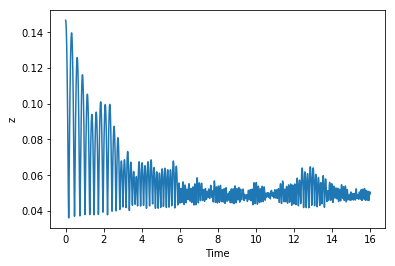

In [15]:
fig, ax = plt.subplots(figsize=(6,4))
ax.plot(ts, zoo.mean(axis=1))
# ax.set_xticks(np.arange(0,t,2))
ax.set_xlabel("Time")
ax.set_ylabel("z")
plt.show()